# TEMPO Vignette: Trajectory Motif Detection After a Shared Perturbation

**T**rajectory **E**nrichment via **M**atrix **P**rofile **O**utcomes

---

## What is TEMPO?

TEMPO is a Python package for detecting trajectory motifs — recurring temporal
patterns — that are enriched in one outcome group relative to another in
longitudinal biological data. The core algorithm, **Harbinger analysis**, uses
the STUMPY matrix profile to find windows of time where cases share a conserved
pattern of change that controls do not.

## The problem TEMPO is designed to solve

Consider a cohort study in which all subjects receive the same perturbation —
a high-fructose diet, a vaccine, a transplant, an infection. When cases and
controls already differ substantially at baseline, that difference is itself
the finding — cross-sectional methods are sufficient and trajectory analysis
adds little. TEMPO is designed for the harder and more interesting problem:
cases and controls look the same at baseline, but only some go on to develop
the outcome. The signal is not in who was different to begin with; it is in
who changed differently after the perturbation, and when.

Standard analyses compare groups at individual timepoints and ask "is this
feature different between cases and controls right now?" They miss the
*shape* of the response: the timing, the rate of change, the pattern of
return to baseline or sustained elevation. TEMPO asks a different question:
**which features followed a distinctive temporal trajectory in cases, and when
did that trajectory diverge from controls?**

A concrete example: in a dietary intervention study, mice receiving a
high-fructose diet all start with identical gut microbiota composition.
Over the following weeks, all animals' compositions shift in response to the
diet. But a subset of animals go on to develop diabetes — and TEMPO can
identify which features showed a distinctive pattern of change in those
animals *before* the clinical outcome was apparent, and pinpoint the window
of time when that divergence occurred.

## What this vignette covers

We walk through a complete Harbinger analysis on a bundled example dataset:
40 subjects (15 cases, 25 controls) measured over 12 timepoints across 15
compositional features. All subjects share the same baseline; 15 go on to
develop the outcome of interest. Three features carry a planted trajectory
motif in the case group between timepoints 3 and 8. Our goal is to recover
those features and that window from the data alone.

The workflow is: **load → explore → preprocess (CLR) → Harbinger → visualise →
statistical follow-up → evaluate against ground truth**.

## Source code and documentation

GitHub: [https://github.com/yourusername/TEMPO](https://github.com/yourusername/TEMPO)


---
## 1  Setup

We import `tempo` and a few standard libraries, then load the bundled example
dataset with a single call to `tempo.load_example_data()`. The function returns
a long-format DataFrame — one row per (subject, timepoint, feature) combination
— and populates `df.attrs` with the ground truth metadata embedded at simulation
time. In a real dataset `df.attrs` would not carry ground truth, but here it
lets us verify our results at the end.

The `outcome` column uses 1 for cases (subjects who developed the outcome) and
0 for controls (subjects who did not). Both groups received the same perturbation
and start from equivalent baselines; what TEMPO is looking for is divergence in
their feature trajectories after the perturbation.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tempo
from tempo import simulate

sns.set_theme(style='whitegrid', palette='muted')

# Load the bundled example dataset
df = tempo.load_example_data()

print(f"Shape       : {df.shape}")
print(f"Subjects    : {df['subject_id'].nunique()} "
      f"({df[df['outcome']==1]['subject_id'].nunique()} cases, "
      f"{df[df['outcome']==0]['subject_id'].nunique()} controls)")
print(f"Timepoints  : {sorted(df['timepoint'].unique())}")
print(f"Features    : {df['feature'].nunique()}")
print()
print("Ground truth (df.attrs):")
for k, v in df.attrs.items():
    print(f"  {k}: {v}")
print()
df.head(6)

Shape       : (7200, 5)
Subjects    : 40 (15 cases, 25 controls)
Timepoints  : [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]
Features    : 15

Ground truth (df.attrs):
  motif_features: ['feature_000', 'feature_001', 'feature_002']
  motif_window: (3, 8)
  n_cases: 15
  n_controls: 25
  motif_strength: 2.5



,subject_id,timepoint,feature,value,outcome
0,case_000,0,feature_000,0.000000,1
1,case_000,0,feature_001,0.091550,1
2,case_000,0,feature_002,0.059321,1
3,case_000,0,feature_003,0.053117,1
4,case_000,0,feature_004,0.099425,1
5,case_000,0,feature_005,0.056614,1


---
## 2  Exploring the Raw Data

Before running any algorithms it is worth looking at the raw trajectories. The
key thing to notice is that cases and controls start from the same baseline —
there is nothing to distinguish them at timepoint 0. The signal we are looking
for emerges *after* the perturbation: a subset of features in cases begins to
diverge from controls and then, in some features, returns toward baseline. This
is what a trajectory motif looks like: a pattern of change with a defined onset,
shape, and offset that is shared among cases but absent in controls.

The dataset uses **compositional measurements** — at every (subject, timepoint)
the 15 feature values sum to 1, representing proportions of a whole. This format
arises in any setting where you measure the relative breakdown of a system: cell
type fractions from a flow cytometry panel, relative metabolite abundances, or
proportional readouts where the total is constrained. The compositional constraint
creates statistical dependencies between features that must be handled before
running the matrix profile (see section 3).

We show individual trajectories for the three signal-carrying features and three
noise features, with the known motif window shaded in gold. Case/control
separation in raw proportion space is often subtle because renormalisation to
sum-to-1 partially absorbs any shift in individual features. The group mean ± SD
plot makes the pattern more apparent.


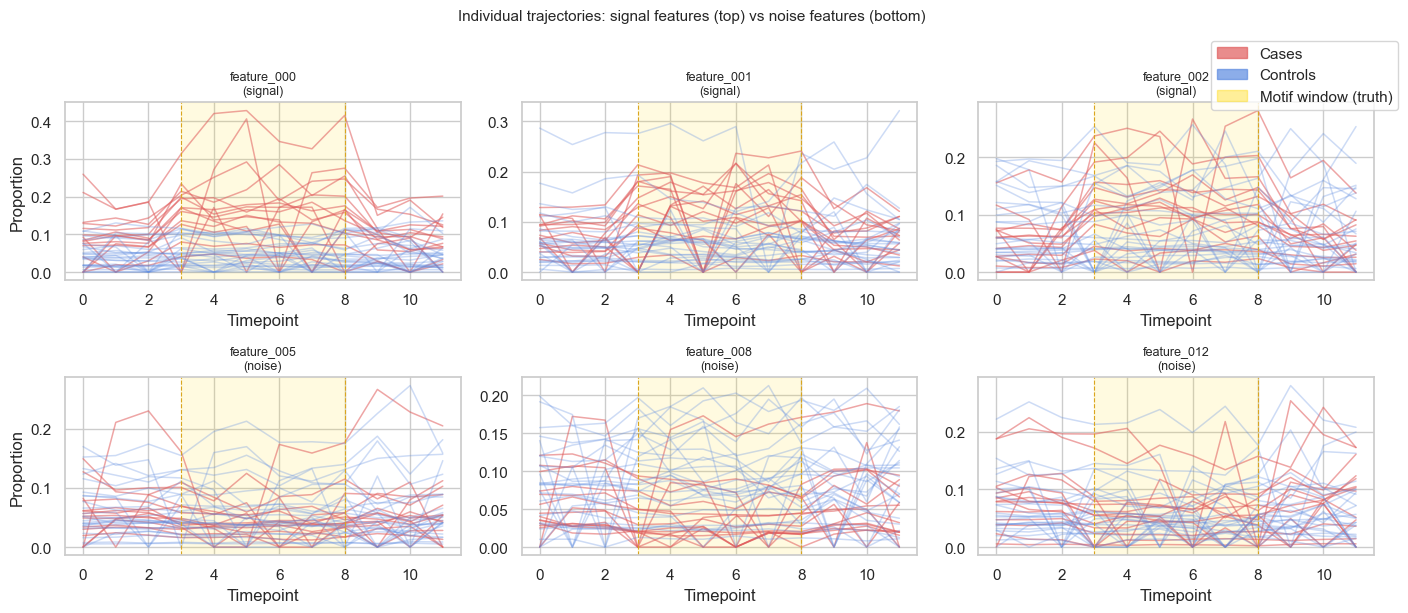

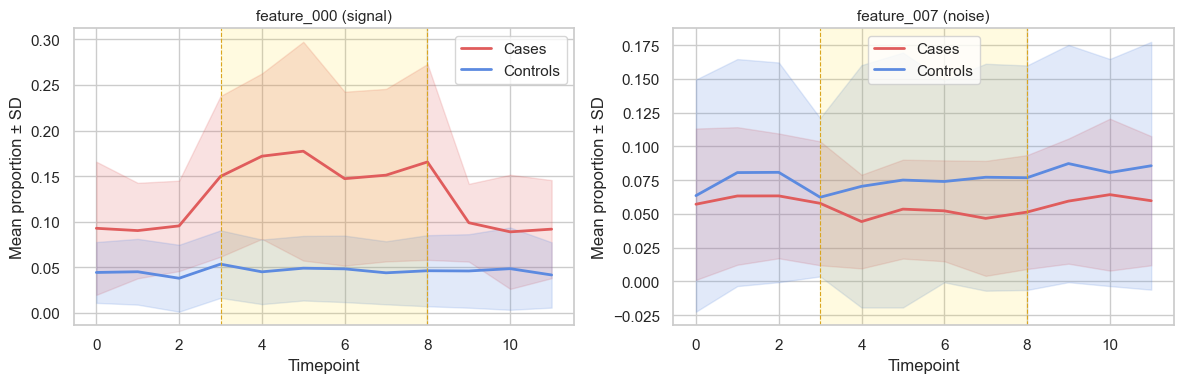

In [2]:
import matplotlib.patches as mpatches

case_color = '#e05c5c'
ctrl_color = '#5c8ae0'

motif_feats = df.attrs['motif_features']   # ['feature_000', 'feature_001', 'feature_002']
noise_feats = ['feature_005', 'feature_008', 'feature_012']
window = df.attrs['motif_window']          # (3, 8)

# ── Plot 1: individual trajectories ──────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(14, 6), sharey=False)

for row_idx, feat_group in enumerate([motif_feats, noise_feats]):
    for col_idx, feat in enumerate(feat_group):
        ax = axes[row_idx, col_idx]
        feat_df = df[df['feature'] == feat]

        for subj, grp in feat_df.groupby('subject_id'):
            outcome = grp['outcome'].iloc[0]
            color = case_color if outcome == 1 else ctrl_color
            alpha = 0.55 if outcome == 1 else 0.30
            ax.plot(grp['timepoint'], grp['value'], color=color, alpha=alpha, lw=1.1)

        ax.axvspan(window[0], window[1], alpha=0.12, color='gold')
        ax.axvline(window[0], color='goldenrod', lw=0.8, ls='--')
        ax.axvline(window[1], color='goldenrod', lw=0.8, ls='--')
        label = f'{feat}\n(signal)' if row_idx == 0 else f'{feat}\n(noise)'
        ax.set_title(label, fontsize=9)
        ax.set_xlabel('Timepoint')
        if col_idx == 0:
            ax.set_ylabel('Proportion')

case_patch = mpatches.Patch(color=case_color, label='Cases', alpha=0.7)
ctrl_patch = mpatches.Patch(color=ctrl_color, label='Controls', alpha=0.7)
window_patch = mpatches.Patch(color='gold', label='Motif window (truth)', alpha=0.4)
fig.legend(handles=[case_patch, ctrl_patch, window_patch],
           loc='upper right', bbox_to_anchor=(1.01, 0.98))
fig.suptitle('Individual trajectories: signal features (top) vs noise features (bottom)',
             fontsize=11, y=1.02)
plt.tight_layout()
plt.show()

# ── Plot 2: group mean ± SD ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, feat, title in zip(
    axes,
    ['feature_000', 'feature_007'],
    ['feature_000 (signal)', 'feature_007 (noise)'],
):
    feat_df = df[df['feature'] == feat]
    for outcome, label, color in [(1, 'Cases', case_color), (0, 'Controls', ctrl_color)]:
        grp = feat_df[feat_df['outcome'] == outcome].groupby('timepoint')['value']
        means, stds = grp.mean(), grp.std()
        ax.plot(means.index, means.values, color=color, lw=2, label=label)
        ax.fill_between(means.index, means - stds, means + stds, color=color, alpha=0.18)
    ax.axvspan(window[0], window[1], alpha=0.12, color='gold')
    ax.axvline(window[0], color='goldenrod', lw=0.8, ls='--')
    ax.axvline(window[1], color='goldenrod', lw=0.8, ls='--')
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Mean proportion ± SD')
    ax.legend()

plt.tight_layout()
plt.show()

---
## 3  Preprocessing with CLR Transform

Before running Harbinger we apply the **Centred Log-Ratio (CLR)** transform.
This step is necessary whenever your measurements are compositional —
i.e., proportions that sum to a constant at each timepoint.

The core problem is that the simplex constraint creates spurious correlations.
Because all features sum to 1, an increase in any one feature mathematically
forces the others down — even if there is no biological relationship between
them. In a perturbation-response study this is particularly problematic: if a
case-enriched feature rises after the perturbation, its signal is automatically
diluted across all other features, and the pairwise correlations you observe
reflect the geometry of the simplex as much as the biology. CLR removes this
constraint by expressing each feature relative to the geometric mean of the
full composition at that timepoint, mapping the data to unconstrained real space
where Euclidean distances are meaningful.

For a composition **x** = (x₁, …, xₚ) at one sample:

> CLR(xᵢ) = log(xᵢ) − mean(log(x₁), …, log(xₚ))

After CLR, values can be negative, are no longer bounded to [0, 1], and sum to
zero within each sample — a useful sanity check. A small pseudo-count (default
1e-6) is added before the log to handle exact zeros, which are common in sparse
compositional data.

If your data is not compositional — raw cytokine concentrations, gene expression
counts, clinical measurements — CLR is not needed and you can pass your data
directly to `harbinger()`.


Max absolute CLR row sum: 1.29e-14  (should be ~0)
CLR value range : [-10.374, 5.693]
Raw value range : [0.000, 0.429]


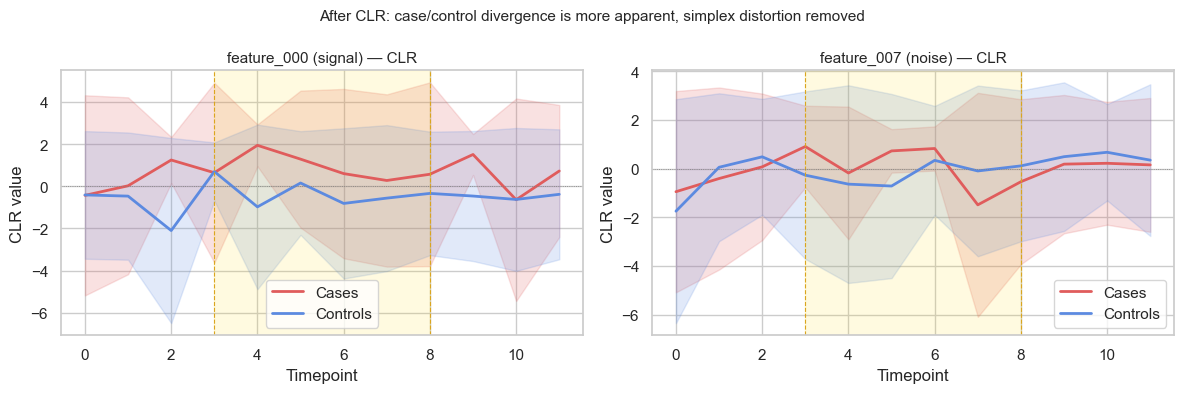

In [3]:
from tempo.preprocess import clr_transform

df_clr = clr_transform(df)

# Sanity check: CLR values sum to zero per (subject, timepoint)
clr_sums = df_clr.groupby(['subject_id', 'timepoint'])['value'].sum()
print(f"Max absolute CLR row sum: {clr_sums.abs().max():.2e}  (should be ~0)")
print(f"CLR value range : [{df_clr['value'].min():.3f}, {df_clr['value'].max():.3f}]")
print(f"Raw value range : [{df['value'].min():.3f}, {df['value'].max():.3f}]")

# ── Plot CLR trajectories ─────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, feat, title in zip(
    axes,
    ['feature_000', 'feature_007'],
    ['feature_000 (signal) — CLR', 'feature_007 (noise) — CLR'],
):
    feat_df = df_clr[df_clr['feature'] == feat]
    for outcome, label, color in [(1, 'Cases', case_color), (0, 'Controls', ctrl_color)]:
        grp = feat_df[feat_df['outcome'] == outcome].groupby('timepoint')['value']
        means, stds = grp.mean(), grp.std()
        ax.plot(means.index, means.values, color=color, lw=2, label=label)
        ax.fill_between(means.index, means - stds, means + stds, color=color, alpha=0.18)
    ax.axvspan(window[0], window[1], alpha=0.12, color='gold')
    ax.axvline(window[0], color='goldenrod', lw=0.8, ls='--')
    ax.axvline(window[1], color='goldenrod', lw=0.8, ls='--')
    ax.axhline(0, color='gray', lw=0.6, ls=':')
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('CLR value')
    ax.legend()

fig.suptitle('After CLR: case/control divergence is more apparent, simplex distortion removed',
             fontsize=11)
plt.tight_layout()
plt.show()

---
## 4  Harbinger Analysis

Harbinger analysis is the core of TEMPO. It uses STUMPY's `mstump` function —
a multidimensional pan-matrix profile — to find the time window where case
subjects simultaneously show the most conserved shared pattern of change.

**How the matrix profile works:** for a given window size *m*, the matrix
profile records, at each position in the time series, the distance to the
nearest matching subsequence elsewhere in the series. Low values indicate
motif positions (the same pattern appears repeatedly); high values indicate
discords (unique, unrepeated events). `mstump` extends this to a stack of time
series — one per case subject — and finds the window position where all cases
simultaneously agree on a shared pattern. The minimum of this cross-subject
matrix profile marks the strongest case-shared motif.

**Why this captures post-perturbation divergence:** because cases and controls
share the same baseline, any motif the matrix profile finds in the case group
that does not appear in controls represents genuine post-perturbation divergence
rather than a pre-existing difference. The enrichment score confirms this by
comparing case and control values at the discovered window.

**Multi-window scanning:** we pass `window_size_range=(3, 6)` to scan all
window lengths from 3 to 6 timepoints. The duration of a biological response
is rarely known in advance, and different features may respond on different
timescales. Scanning a range lets each feature select its own best window.

**Enrichment score and p-value:** at the winning window, the enrichment score
is mean(case values) − mean(control values). A permutation test converts this
to a p-value by randomly shuffling case/control labels 999 times, building a
null distribution of scores expected if outcome assignment were random.

**Caveat:** scanning multiple window sizes introduces a mild selection bias.
Treat these p-values as exploratory; use a fixed, pre-specified window for
confirmatory testing (section 7).


In [4]:
results = tempo.harbinger(df_clr, window_size_range=(3, 6), top_k=15, n_permutations=999, seed=42)

print("Harbinger results (top 15 features, sorted by enrichment score):")
print(results[['feature', 'window_size', 'motif_window',
               'enrichment_score', 'p_value']].to_string(index=False))


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Harbinger results (top 15 features, sorted by enrichment score):
    feature  window_size motif_window  enrichment_score  p_value
feature_000            3       (2, 4)          2.067850   0.0000
feature_002            3       (3, 5)          1.376540   0.0240
feature_007            4       (3, 6)          0.891042   0.0340
feature_012            5       (1, 5)          0.858634   0.0551
feature_013            3      (9, 11)          0.727309   0.1371
feature_014            6       (1, 6)          0.697056   0.0971
feature_008            3       (0, 2)          0.661649   0.1401
feature_001            5       (0, 4)          0.591855   0.1471
feature_011            4       (3, 6)          0.566351   0.1562
feature_003            3      (8, 10)          0.418538   0.2763
feature_005            3       (1, 3)          0.410919   0.1502
feature_010            3       (4, 6)          0.279334   0.3233
feature_006            5       (5, 9)          0.123110   0.4084
feature_009            6 

---
## 5  Visualising the Motifs

`tempo.plot_motifs()` draws individual subject trajectories overlaid with group
mean ± 1 SD ribbons for cases and controls, with the discovered motif window
shaded in gold. This is the most direct way to visually confirm that Harbinger
found a real signal rather than a statistical artefact.

For a genuine trajectory motif, you should see: cases and controls overlapping
before the window (shared baseline), the case ribbon diverging from controls
inside the window (the post-perturbation pattern), and potentially a return
toward baseline after the window. Noise features should show overlapping
ribbons throughout, with no systematic divergence inside the gold region.

The plot uses CLR-transformed values — positive values mean the feature is
elevated relative to the geometric mean composition at that timepoint, negative
means suppressed. The baseline (CLR = 0) corresponds to a feature being exactly
at its geometric mean proportion.


Top 4 features : ['feature_000', 'feature_002', 'feature_007', 'feature_012']
Motif window   : (2, 4)


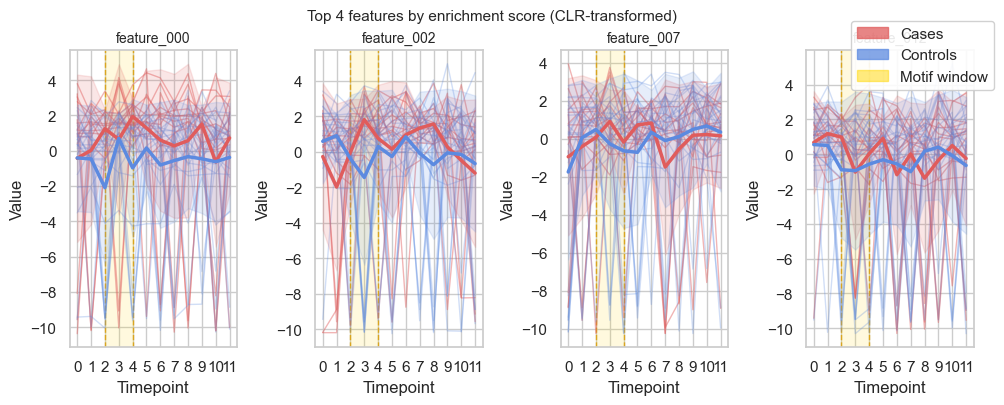

In [5]:
top_features = results['feature'].head(4).tolist()
top_window = results['motif_window'].iloc[0]

print(f"Top 4 features : {top_features}")
print(f"Motif window   : {top_window}")

fig = tempo.plot_motifs(df_clr, features=top_features, motif_window=top_window)
fig.suptitle('Top 4 features by enrichment score (CLR-transformed)',
             fontsize=11, y=1.01)
plt.show()

---
## 6  Enrichment Summary

`tempo.plot_enrichment()` gives a two-panel overview of the full Harbinger
results table.

The **left panel** shows enrichment scores as horizontal bars. Features with a
permutation p-value below 0.05 are coloured red (significant); others are grey.
Significance stars (* p < 0.05, ** p < 0.01, *** p < 0.001) are appended to
feature labels for quick visual scanning.

The **right panel** shows −log₁₀(p-value). The dashed red line at
−log₁₀(0.05) ≈ 1.30 marks the significance threshold. Bars clearing this line
are significant. This panel makes it easy to compare the strength of evidence
across features, not just which side of the binary threshold they fall on.

Together, the two panels answer both "which features show a case-enriched
trajectory?" and "how strong is the evidence?". Features at the top of both
panels are the strongest candidates for follow-up mechanistic study or
validation in an independent cohort.


/Users/caitlinbumby/Documents/Projects/TEMPO/tempo/viz.py:238: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.tight_layout()
/Users/caitlinbumby/Documents/Projects/TEMPO/tempo/viz.py:238: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.tight_layout()
/Users/caitlinbumby/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/caitlinbumby/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


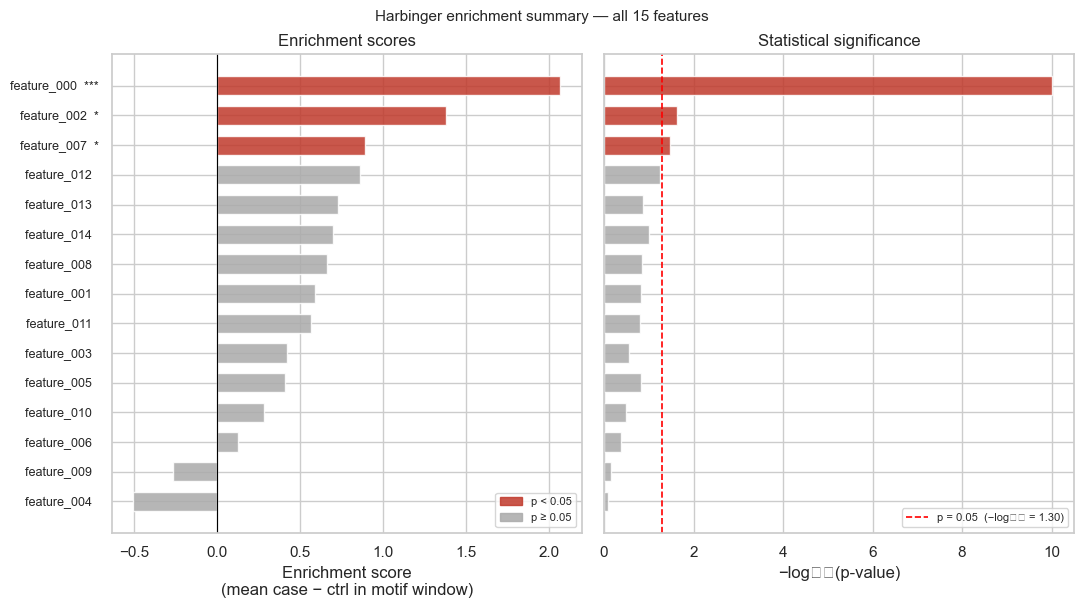

In [6]:
fig = tempo.plot_enrichment(results, top_k=15)
fig.suptitle('Harbinger enrichment summary — all 15 features',
             fontsize=11, y=1.01)
plt.show()

---
## 7  Follow-up Statistical Testing with a Fixed Window

The permutation test inside Harbinger is run on the data-adaptive window
selected by the matrix profile. This is appropriate for discovery, but the
p-values carry a selection effect — we tested many windows and reported the best.

For confirmatory analysis, best practice is to fix the window in advance based
on prior biological knowledge (e.g. the known duration of an acute immune
response) or a pre-registered analysis plan, then test only that window.
`tempo.permutation_test()` provides exactly this: a standalone permutation test
on a single, pre-specified (feature, window) pair. Because there is no window
selection involved, the p-value is more conservative and more directly
interpretable as the probability of observing this level of case enrichment by
chance under random outcome assignment.

Here we test the top-ranked feature at the window discovered by Harbinger. In
a rigorous two-stage analysis, the window would be specified independently of
the data being tested — for example, from a prior study or a held-out cohort.


Confirmatory permutation test for feature_000 at window (2, 4):
  observed_score: 2.0678
  p_value: 0.0000
  null_mean: -0.0774
  null_sd: 0.6892
  n_permutations: 999


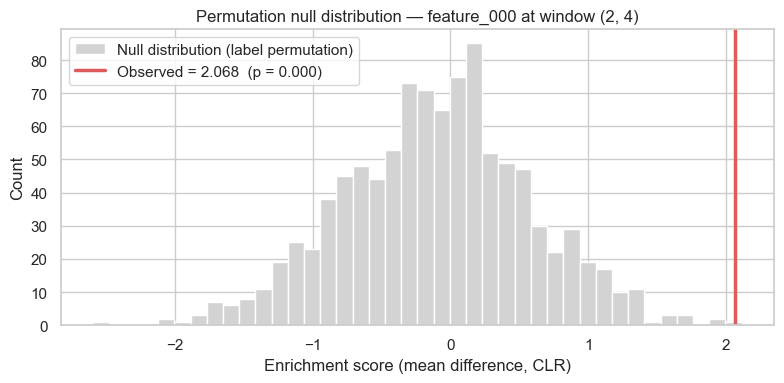

In [7]:
top_feature = results['feature'].iloc[0]
discovered_window = results['motif_window'].iloc[0]

print(f"Confirmatory permutation test for {top_feature} at window {discovered_window}:")
perm_result = tempo.permutation_test(
    df_clr, top_feature, discovered_window, n_permutations=999, seed=42
)
for k, v in perm_result.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

# ── Null distribution plot ────────────────────────────────────────────────────
import numpy as np
rng = np.random.default_rng(42)
null_sample = rng.normal(perm_result['null_mean'], perm_result['null_sd'], 999)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(null_sample, bins=40, color='lightgray', edgecolor='white',
        label='Null distribution (label permutation)')
ax.axvline(perm_result['observed_score'], color=case_color, lw=2.5,
           label=f"Observed = {perm_result['observed_score']:.3f}  "
                 f"(p = {perm_result['p_value']:.3f})")
ax.set_xlabel('Enrichment score (mean difference, CLR)')
ax.set_ylabel('Count')
ax.set_title(f'Permutation null distribution — {top_feature} at window {discovered_window}')
ax.legend()
plt.tight_layout()
plt.show()

---
## 8  Evaluating Against Ground Truth

In a real study we do not know which features carry signal or exactly when the
response window falls — that is what we are trying to discover. But because this
is a simulated dataset, `df.attrs` records the planted ground truth, letting us
measure how well Harbinger recovered it using three metrics:

**Feature recall** — what fraction of the true signal features were detected?
A recall of 1.0 means all three were found; 0.67 means two out of three.

**Feature precision** — of the features flagged as significant, what fraction
were genuinely signal-carrying? High precision means few false positives.

**Window Jaccard** — how much do the detected and true windows overlap?
Jaccard = |detected ∩ true| / |detected ∪ true|, treating each timepoint as a
set element. 1.0 = exact match; 0.0 = no overlap.

In practice, recall matters more than precision for hypothesis generation — it
is better to follow up on a few false positives than to miss real signal.
Precision matters more when downstream validation is expensive or when the
results will be used to make a clinical decision.


Significant features (p < 0.05) : ['feature_000', 'feature_002', 'feature_007']
Detected window (top feature)   : (2, 4)
True signal features            : ['feature_000', 'feature_001', 'feature_002']
True response window            : (3, 8)

Evaluation report:
  feature_recall: 0.667
  feature_precision: 0.667
  window_jaccard: 0.286
  true_features: ['feature_000', 'feature_001', 'feature_002']
  detected_features: ['feature_000', 'feature_002', 'feature_007']
  true_window: (3, 8)
  detected_window: (2, 4)


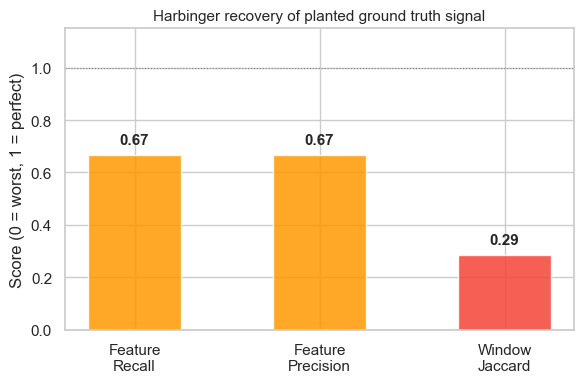

In [8]:
# Use features with p < 0.05 as the detected set
sig_features = results[results['p_value'] < 0.05]['feature'].tolist()
detected_window = results['motif_window'].iloc[0]

print(f"Significant features (p < 0.05) : {sig_features}")
print(f"Detected window (top feature)   : {detected_window}")
print(f"True signal features            : {df.attrs['motif_features']}")
print(f"True response window            : {df.attrs['motif_window']}")
print()

report = simulate.evaluation_report(
    detected_features=sig_features,
    detected_window=detected_window,
    df=df,
)
print("Evaluation report:")
for k, v in report.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.3f}")
    else:
        print(f"  {k}: {v}")

# ── Bar chart of the three metrics ───────────────────────────────────────────
metrics = ['feature_recall', 'feature_precision', 'window_jaccard']
labels  = ['Feature\nRecall', 'Feature\nPrecision', 'Window\nJaccard']
values  = [report[m] for m in metrics]
colors  = ['#4caf50' if v >= 0.8 else '#ff9800' if v >= 0.5 else '#f44336'
           for v in values]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, values, color=colors, alpha=0.85, width=0.5)
ax.set_ylim(0, 1.15)
ax.axhline(1.0, color='gray', lw=0.8, ls=':')
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width() / 2, val + 0.03,
            f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_title('Harbinger recovery of planted ground truth signal', fontsize=11)
ax.set_ylabel('Score (0 = worst, 1 = perfect)')
plt.tight_layout()
plt.show()